### Part 1: Data Reading

In [1]:
# basic imports
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from IPython.display import HTML
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
import gmaps

In [2]:
plt.rcParams["figure.figsize"] = (16,12)
pd.set_option('display.max_columns', 500)

In [3]:
# read the data
df = pd.read_csv('dump/realtimedata.csv', header=None)
clustering = pd.read_csv('clustering.csv')

In [4]:
# rename columns of the actual df
df.columns = ['ServiceDelivery_ResponseTimestamp',
'ServiceDelivery_ProducerRef',
'ServiceDelivery_Status',
'ServiceDelivery_MoreData',
'StopMonitoringDelivery_Version',
'StopMonitoringDelivery_ResponseTimestamp',
'StopMonitoringDelivery_RequestMessageRef',
'MonitoredStopVisit_RecordedAtTime',
'StopNumber',
'MonitoredVehicleJourney_LineRef',
'MonitoredVehicleJourney_DirectionRef',
'FramedVehicleJourneyRef_DataFrameRef',
'FramedVehicleJourneyRef_DatedVehicleJourneyRef',
'RouteNumber',
'MonitoredVehicleJourney_OperatorRef',
'DestinationStop',
'DestinationName',
'MonitoredVehicleJourney_Monitored',
'MonitoredVehicleJourney_InCongestion',
'MonitoredVehicleJourney_BlockRef',
'MonitoredVehicleJourney_VehicleRef',
'MonitoredCall_VisitNumber',
'MonitoredCall_VehicleAtStop',
'MonitoredCall_AimedArrivalTime',
'MonitoredCall_ExpectedArrivalTime',
'MonitoredCall_AimedDepartureTime',
'MonitoredCall_ExpectedDepartureTime',
'scrapetime',
'aimed_minutes_due',
'expected_minutes_due',
'ID',
'Day',
'Month',
'Season',
'TimeOfDay',
'Special',
'BusShare']

### Part 2: Data Re-joining

Once we have the clusters, we want to map it back to the realtime data to observe a clear pattern in the dataset. We will start by joining the cluster aggregated data with the realtime data using the stop number and the directional reference as join keys.

In [5]:
df = df[['StopNumber', 'MonitoredVehicleJourney_DirectionRef', 'MonitoredCall_ExpectedArrivalTime', 'MonitoredCall_AimedArrivalTime', 'Day', 'Month', 'TimeOfDay']]

In [6]:
# create delay_sec
df['MonitoredCall_AimedArrivalTime'] = df['MonitoredCall_AimedArrivalTime'].astype('datetime64')
df['MonitoredCall_ExpectedArrivalTime'] = df['MonitoredCall_ExpectedArrivalTime'].astype('datetime64')
df['delay_sec'] = (df['MonitoredCall_ExpectedArrivalTime'] - df['MonitoredCall_AimedArrivalTime'])/np.timedelta64(1,'s')

### Part 3: Data Re-joining

Next we need to create three new variables for cluster analysis. They are hour, day and month. We want to see the traffic pattern across various times of the day, over the weekdays and weekends and over the months to see if they exhibit any seasonality.

In [7]:
# create day
df['Day'] = df['MonitoredCall_AimedArrivalTime'].apply(lambda x: x.strftime("%A"))

In [8]:
# create month
df['Month'] = df['MonitoredCall_AimedArrivalTime'].apply(lambda x: x.month)

In [9]:
# create time of day
df['TimeOfDay'] = df['MonitoredCall_AimedArrivalTime'].apply(lambda x: x.hour)

In [10]:
# replace the values for direction of the traffic
df.MonitoredVehicleJourney_DirectionRef = df.MonitoredVehicleJourney_DirectionRef.replace({'Inbound':'I', 'Outbound':'O'})

In [11]:
clustering = clustering[['StopNumber', 'MonitoredVehicleJourney_DirectionRef', 'cluster_kmeans']]

In [12]:
df_cluster = df.merge(clustering, left_on=['StopNumber', 'MonitoredVehicleJourney_DirectionRef'], right_on=['StopNumber', 'MonitoredVehicleJourney_DirectionRef'])

In [13]:
# df_cluster.to_csv('cluster_time_analysis.csv', index=False)

In [14]:
df_cluster.head()

,StopNumber,MonitoredVehicleJourney_DirectionRef,MonitoredCall_ExpectedArrivalTime,MonitoredCall_AimedArrivalTime,Day,Month,TimeOfDay,delay_sec,cluster_kmeans
0,12,I,2019-01-31 14:17:31,2019-01-31 14:18:02,Thursday,1,14,-31.0,0
1,12,I,2019-01-31 14:31:58,2019-01-31 14:33:02,Thursday,1,14,-64.0,0
2,12,I,2019-01-31 13:56:33,2019-01-31 13:42:00,Thursday,1,13,873.0,0
3,12,I,2019-01-31 14:14:06,2019-01-31 14:12:00,Thursday,1,14,126.0,0
4,12,I,2019-01-29 14:13:59,2019-01-29 14:11:52,Tuesday,1,14,127.0,0


In [15]:
df_cluster['TimeOfDay'] = df.TimeOfDay.astype('str')
df_cluster['Month'] = df.Month.astype('str')
df_cluster['delay'] = df.delay_sec/60

### Part 4: Hourly Analysis

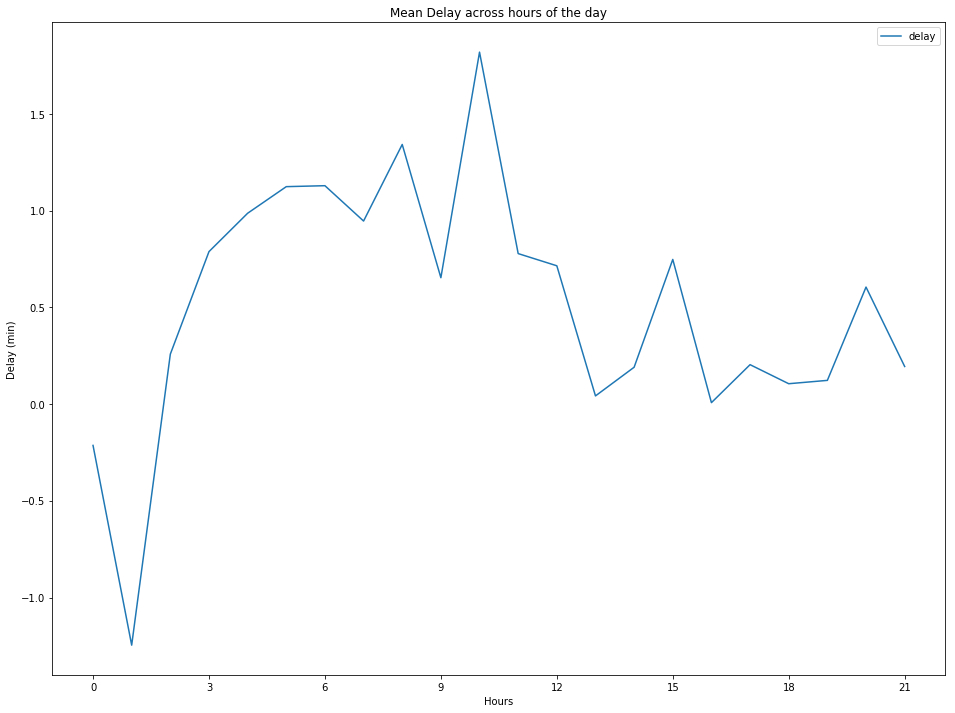

In [16]:
temp = df_cluster[df_cluster.cluster_kmeans == 2]
temp = temp.groupby('TimeOfDay').agg({'delay': 'mean'}).reset_index()
temp.plot();
plt.xticks(np.arange(0, 24, step=3));
plt.title("Mean Delay across hours of the day");
plt.xlabel("Hours");
plt.ylabel("Delay (min)");

We can conclude that over the nights, the delay increases. Human behaviour, sleepiness can be some of the plausible reason behind it.

However again we see a peak delay during the 10-11 am. Maybe rush for office, the roads being filled with other vehicles during this time can account up for it. AGain we see a two peaks around 3 pm and 8 pm. Maybe they are reasons for breaking up of schools, factory shift changes etc and returning for office respectively.

### Part 5: Weekly Analysis

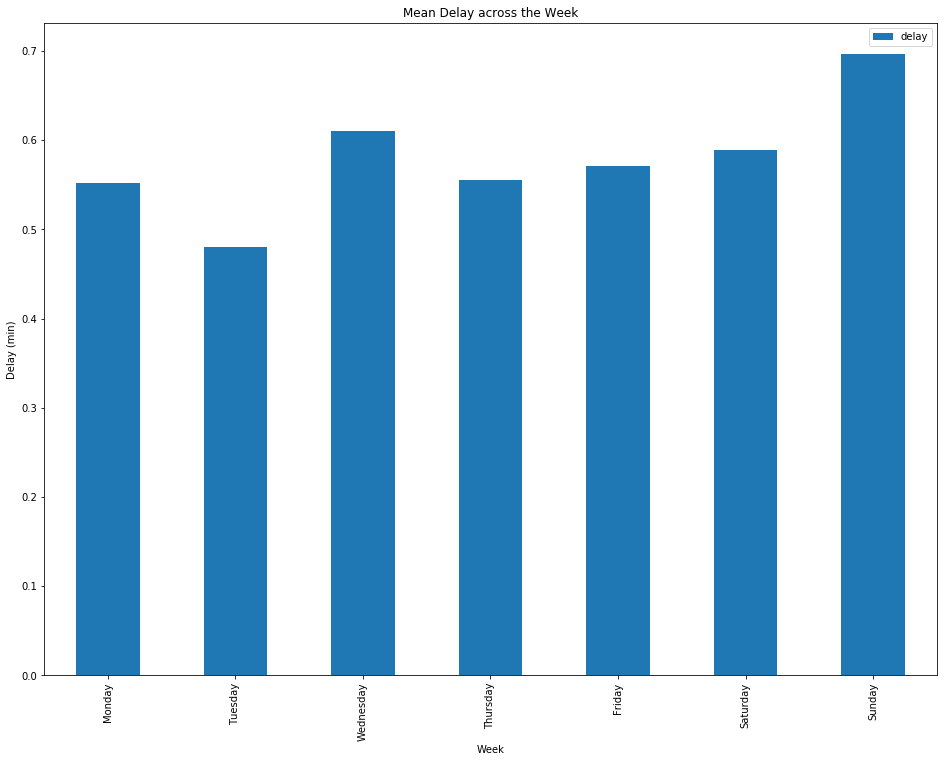

In [17]:
temp = df_cluster[df_cluster.cluster_kmeans == 2]
temp = temp.groupby('Day').agg({'delay': 'mean'})
temp.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot.bar();
plt.title("Mean Delay across the Week");
plt.xlabel("Week");
plt.ylabel("Delay (min)");

There's as such no pattern in the data except a peak during Sunday and a drop during Tuesday. This requires more expertise in the domain and the region to make a comment on.